In [ ]:
pip install torchinfo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset
from torchinfo import summary
import functools
from torch.autograd import Variable
from torch.optim import lr_scheduler

In [ ]:
print(torch.cuda.device_count())
device = torch.device("cuda:0" if (torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
if torch.cuda.device_count()>0:
  print(torch.cuda.get_device_name())

1
Tesla P100-PCIE-16GB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set parameters
BATCH_SIZE = 32
IMG_SIZE = 128
MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]
transform = T.Compose([T.Resize((IMG_SIZE,IMG_SIZE))
                       ,T.CenterCrop(IMG_SIZE)
                       ,T.ToTensor()
                       ,T.Normalize(MEAN,STD)
                      ])
# Dataloading function
def dataset_loader(img_path, transform):
  data = torchvision.datasets.ImageFolder(root = img_path,
                                          transform = transform)
  data_loader = torch.utils.data.DataLoader(data
                                          ,batch_size = BATCH_SIZE
                                          ,shuffle = True)
  return data_loader

img_path = "/content/drive/MyDrive/Liminal Photos"

In [ ]:
liminal_loader = dataset_loader(img_path,transform)

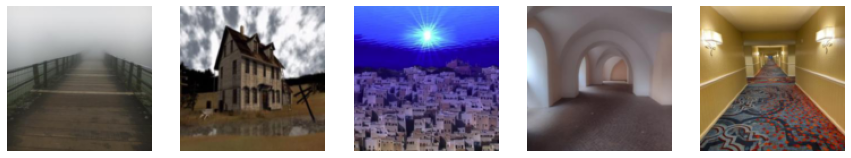

In [ ]:
images = next(iter(liminal_loader))[0]
fig, ax = plt.subplots(1,5)
fig.set_figheight(30)
fig.set_figwidth(15)
for i in range(5):
    x = images[i]* torch.tensor(STD)[:, None, None] + torch.tensor(MEAN)[:, None, None]
    ax[i].imshow(x.squeeze().permute(1,2,0))
    ax[i].axis("off")

In [ ]:
# num channels
nc = 3

# generator input/latent vector z
nz = 100

# feature map size in gen
ngf = IMG_SIZE

# feature map size in disc
ndf = IMG_SIZE

# epochs
epochs = 500

# learning rate
lr = 0.0002

# beta for Adam
beta1 = 0.5

In [ ]:
# initialize starting weights from normal dist with mean = 0 and std = 0.2 per DCGAN Paper
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(nn.ConvTranspose2d(nz, ngf*16, 4, 1, 0, bias=False)
                              ,nn.BatchNorm2d(ngf*16)
                              ,nn.ReLU(True),

                              nn.ConvTranspose2d(ngf*16, ngf*8, 4, 2, 1, bias=False)
                              ,nn.BatchNorm2d(ngf*8)
                              ,nn.ReLU(True)

                              ,nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False)
                              ,nn.BatchNorm2d(ngf*4)
                              ,nn.ReLU(True)

                              ,nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False)
                              ,nn.BatchNorm2d(ngf*2)
                              ,nn.ReLU(True)
                              
                              ,nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False)
                              ,nn.BatchNorm2d(ngf)
                              ,nn.ReLU(True)
                              
                              ,nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)
                              ,nn.Tanh())
  def forward(self, input):
    return self.gen(input)

In [ ]:
GenNet = Generator().to(device)
GenNet.apply(weights_init)
summary(GenNet)

Layer (type:depth-idx)                   Param #
Generator                                --
├─Sequential: 1-1                        --
│    └─ConvTranspose2d: 2-1              3,276,800
│    └─BatchNorm2d: 2-2                  4,096
│    └─ReLU: 2-3                         --
│    └─ConvTranspose2d: 2-4              33,554,432
│    └─BatchNorm2d: 2-5                  2,048
│    └─ReLU: 2-6                         --
│    └─ConvTranspose2d: 2-7              8,388,608
│    └─BatchNorm2d: 2-8                  1,024
│    └─ReLU: 2-9                         --
│    └─ConvTranspose2d: 2-10             2,097,152
│    └─BatchNorm2d: 2-11                 512
│    └─ReLU: 2-12                        --
│    └─ConvTranspose2d: 2-13             524,288
│    └─BatchNorm2d: 2-14                 256
│    └─ReLU: 2-15                        --
│    └─ConvTranspose2d: 2-16             6,144
│    └─Tanh: 2-17                        --
Total params: 47,855,360
Trainable params: 47,855,360
Non-trainable

In [ ]:
print(GenNet)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Bat

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.dscr = nn.Sequential(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
                              ,nn.LeakyReLU(0.2, inplace = True)
                              
                              ,nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False)
                              ,nn.BatchNorm2d(ndf*2)
                              ,nn.LeakyReLU(0.2, inplace = True)
                              
                              ,nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False)
                              ,nn.BatchNorm2d(ndf*4)
                              ,nn.LeakyReLU(0.2, inplace = True)
                              
                              ,nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False)
                              ,nn.BatchNorm2d(ndf*8)
                              ,nn.LeakyReLU(0.2, inplace = True)

                              ,nn.Conv2d(ndf*8, ndf*16, 4, 2, 1, bias=False)
                              ,nn.BatchNorm2d(ndf*16)
                              ,nn.LeakyReLU(0.2, inplace=True)
                              
                              ,nn.Conv2d(ndf*16, 1, 4, 1, 0, bias=False)
                              ,nn.Sigmoid())
  def forward(self, input):
    return self.dscr(input)

In [ ]:
DiscNet = Discriminator().to(device)
DiscNet.apply(weights_init)
summary(DiscNet)

Layer (type:depth-idx)                   Param #
Discriminator                            --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       6,144
│    └─LeakyReLU: 2-2                    --
│    └─Conv2d: 2-3                       524,288
│    └─BatchNorm2d: 2-4                  512
│    └─LeakyReLU: 2-5                    --
│    └─Conv2d: 2-6                       2,097,152
│    └─BatchNorm2d: 2-7                  1,024
│    └─LeakyReLU: 2-8                    --
│    └─Conv2d: 2-9                       8,388,608
│    └─BatchNorm2d: 2-10                 2,048
│    └─LeakyReLU: 2-11                   --
│    └─Conv2d: 2-12                      33,554,432
│    └─BatchNorm2d: 2-13                 4,096
│    └─LeakyReLU: 2-14                   --
│    └─Conv2d: 2-15                      32,768
│    └─Sigmoid: 2-16                     --
Total params: 44,611,072
Trainable params: 44,611,072
Non-trainable params: 0

In [ ]:
print(DiscNet)

Discriminator(
  (dscr): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(2048, eps=

In [ ]:
# Initialize binary cross entropy loss fn
criterion = nn.BCELoss()

# Generate batch of latent vectors to visualize progression of generator
noise = torch.randn(IMG_SIZE, nz, 1, 1, device=device)

# create labels
real_label = 0.9
fake_label = 0.

optD = torch.optim.Adam(DiscNet.parameters(), lr=lr, betas=(beta1, 0.999))
optG = torch.optim.Adam(GenNet.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_loss = []
D_loss = []
iters = 0
for ep in range(epochs):
  for i, data in enumerate(liminal_loader, 0):

    ### Update Discriminator Network ###

    ## train with all real batch ##
    DiscNet.zero_grad()
    # format batch
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # forward pass real batch through D
    output = DiscNet(real_cpu).view(-1)
    # calc loss on all-real batch
    errD_real = criterion(output, label)
    # calc gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()

    ## train with all fake batch ##
    # generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # generate fake image 
    fake = GenNet(noise)
    label.fill_(fake_label)
    # classify fake batch with D
    output = DiscNet(fake.detach()).view(-1)
    # calculate D's loss on the all fake batch
    errD_fake = criterion(output, label)
    # calc gradients for this batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # compute error of D as sum over fake and real batches
    errD = errD_real + errD_fake
    # update D
    optD.step()

    ### Update Generator Network ###
    GenNet.zero_grad()
    label.fill_(real_label) # fake labels are real for generator cost
    # since we just updated D, do all fake forward pass through D again
    output = DiscNet(fake).view(-1)
    # calc Generator loss based on output
    errG = criterion(output, label)
    # calc gradients for Generator
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update generator 
    optG.step()

    # output training stats
    if i%50 == 0:
      print(f"Epoch: {ep}, Iter: {i}, GenLoss: {errG.item()}, DiscLoss: {errD.item()}, D(x): {D_x}, D(G(x)): {D_G_z1},{D_G_z2}")
    # check images 
    if (iters % 100==0) or ((ep==epochs-1) and (i==len(liminal_loader)-1)):
      with torch.no_grad():
        fake = GenNet(noise).detach().cpu()
        y = fake[0]*torch.tensor(STD)[:, None, None] + torch.tensor(MEAN)[:, None, None]
        plt.imshow(y.permute(1,2,0))
        plt.axis("off")
        plt.show()
      img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))
    iters+=1

In [ ]:
#noise = torch.randn(IMG_SIZE, nz, 1, 1, device=device)
img = GenNet(noise).detach().cpu()
#fig, ax = plt.subplots(1,15)
#fig.set_figheight(30)
#fig.set_figwidth(30)
plt.figure(figsize=(30,30))
for i in range(0,25):
  plt.subplot(7,5,i+1)
  y = img[i]*torch.tensor(STD)[:, None, None] + torch.tensor(MEAN)[:, None, None]
  plt.imshow(y.permute(1,2,0))
  plt.axis("off")
  #ax[i].imshow(y.permute(1,2,0))
  #ax[i].axis("off")

In [ ]:
z = img[21]*torch.tensor(STD)[:, None, None] + torch.tensor(MEAN)[:, None, None]
plt.imshow(z.permute(1,2,0))
plt.axis("off")
plt.show()

In [ ]:
fig = plt.figure(figsize=(16,16))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
#ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

#HTML(ani.to_jshtml())

In [ ]:
torch.save(GenNet.state_dict(), "Generator2.pth")
torch.save(DiscNet.state_dict(), "Discriminator2.pth")

In [ ]:
len(img)